In [2]:
import os
os.getcwd()
os.chdir(r'/home/manhducnmd/manhducnmd/Delphes-3.5.0')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import pickle

In [51]:
os.environ["PATH"]='/home/manhducnmd/latex/bin/x86_64-linux'
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.family'] = 'sans-serif'


In [5]:
import ROOT
ROOT.gSystem.Load("libDelphes")

Welcome to JupyROOT 6.20/08


0

In [6]:
try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

In [85]:
ROOT.gSystem.Load("libDelphes")
file = ROOT.TFile.Open("/home/manhducnmd/manhducnmd/zprimeboson_lepton/Events/run_01/tag_1_delphes_events.root")
tree = file.Get("Delphes")

# Access branches
towers = ROOT.TClonesArray("Tower")
tracks = ROOT.TClonesArray("Track")
muons = ROOT.TClonesArray("Muon")
electrons = ROOT.TClonesArray("Electron")
tree.SetBranchAddress("Tower", ROOT.AddressOf(towers))
tree.SetBranchAddress("Track", ROOT.AddressOf(tracks))
tree.SetBranchAddress("Muon", ROOT.AddressOf(muons))
tree.SetBranchAddress("Electron", ROOT.AddressOf(electrons))

4

In [86]:
image_track_eta = []
image_track_phi = []
image_track_Pt = []
image_tower_eta = []
image_tower_phi = []
image_tower_Et = []

Mll_total_zprimeboson = []
for entry in range(tree.GetEntries()):
    tree.GetEntry(entry)
    if muons.GetEntries() + electrons.GetEntries() >= 2: #Choose events with more than 2 leptons
        Pt_leptons = []
        P4_leptons = []
        if muons.GetEntries() > 0:
            for muon in muons:
                Pt_leptons.append(muon.P4().Pt())
                P4_leptons.append(muon.P4())
        if electrons.GetEntries() > 0:
            for electron in electrons:
                Pt_leptons.append(electron.P4().Pt())
                P4_leptons.append(electron.P4())
        Pt_leptons = np.array(Pt_leptons)
        P4_leptons = np.array(P4_leptons)
        sorted_indices = np.argsort(Pt_leptons)
        P4_leptons_sorted = P4_leptons[sorted_indices]
        Pt_leptons_sorted = Pt_leptons[sorted_indices]
        Mll_total_zprimeboson.append((P4_leptons_sorted[-1] + P4_leptons_sorted[-2]).M())
        
        constituent_track_eta = []
        constituent_track_phi = []
        constituent_track_Pt = []
        
        constituent_tower_eta = []
        constituent_tower_phi = []
        constituent_tower_Et = []
        for track in tracks:
            constituent_track_eta.append(track.Eta)
            constituent_track_phi.append(track.Phi)
            constituent_track_Pt.append(track.PT)            
        for tower in towers:
            constituent_tower_eta.append(tower.Eta)
            constituent_tower_phi.append(tower.Phi)
            constituent_tower_Et.append(tower.ET)
        image_track_eta.append(constituent_track_eta)
        image_track_phi.append(constituent_track_phi)
        image_track_Pt.append(constituent_track_Pt)
        
        image_tower_eta.append(constituent_tower_eta)
        image_tower_phi.append(constituent_tower_phi)
        image_tower_Et.append(constituent_tower_Et)

        
image_track_eta = np.array(image_track_eta)
image_track_phi = np.array(image_track_phi)
image_track_Pt = np.array(image_track_Pt)
image_tower_eta = np.array(image_tower_eta)
image_tower_phi = np.array(image_tower_phi)
image_tower_Et = np.array(image_tower_Et)
        


<ipython-input-86-4341fd2c5ff0>:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_track_eta = np.array(image_track_eta)
<ipython-input-86-4341fd2c5ff0>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_track_phi = np.array(image_track_phi)
<ipython-input-86-4341fd2c5ff0>:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

In [45]:
print(len(Mll_total_wboson))
print(len(Mll_total_zboson))
print(len(Mll_total_zprimeboson))

3244
7522
5380


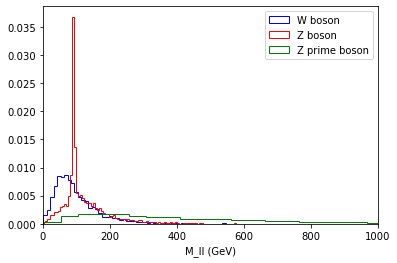

In [59]:
plt.hist(Mll_total_wboson, bins = 'auto', density = True, edgecolor = 'b', histtype = 'step', label = 'W boson')
plt.hist(Mll_total_zboson, bins = 'auto', density = True, edgecolor = 'r', histtype = 'step', label = 'Z boson')
plt.hist(Mll_total_zprimeboson, bins = 'auto', density = True, edgecolor = 'g', histtype = 'step', label = 'Z prime boson')
plt.legend()
plt.xlabel("M_ll (GeV)")
plt.xlim(0, 1000)
plt.savefig(r"/home/manhducnmd/manhducnmd/ML for Particle Physics/Mll plot")
plt.show()

In [65]:
xpixels = 40
ypixels = 40

def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, weights):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z, x_edges, y_edges = np.histogram2d(etas, phis, bins = [xpixels, ypixels], weights = weights)
    return z

# preprocess the jet
def preprocessing(x ,y, weights, rotate=True, flip=True):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = np.average(x, weights = weights)
    y_centroid = np.average(y, weights = weights)
    x = x - x_centroid
    y = y - y_centroid

    y[y < -np.pi] += 2*np.pi
    y[y > np.pi] -= 2*np.pi
    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_axis, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])

        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y

    n_flips = 0

    # Flipping
    if flip:
        if x_rot[np.argmax(weights)] < 0.:
            x_rot = -x_rot
            n_flips  += 1
        if y_rot[np.argmax(weights)] < 0.:
            y_rot = -y_rot
            n_flips += 1

    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img(etas, phis, pT, rotate, flip):

    weights = pT

    etas, phis = preprocessing(etas, phis, weights, rotate, flip)

    z_ori = orig_image(etas, phis, weights)

    return z_ori

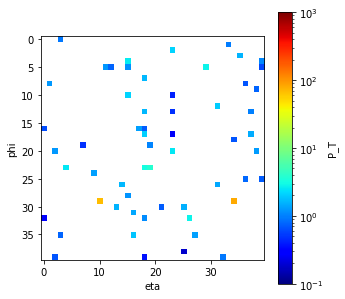

In [77]:
all_images_track_wboson_lepton = []
for idx, xd in enumerate(image_track_eta):
    etas = np.array(image_track_eta[idx])
    phis = np.array(image_track_phi[idx])
    Pts = np.array(image_track_Pt[idx])
    all_images_track_wboson_lepton.append(constit_to_img(etas, phis, Pts, True, True))
    
#masked_data = np.ma.masked_equal(np.mean(all_images_track_wboson_lepton, axis = 0), 0.)
masked_data = all_images_track_wboson_lepton[0]
# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-1, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("P_T")
plt.xlabel("eta")
plt.ylabel("phi")
plt.savefig("Individual track picture - W boson")
#plt.gca().invert_yaxis()
plt.show()




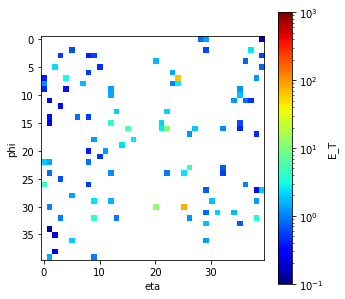

In [78]:
all_images_tower_wboson_lepton = []
for idx_1, xd_1 in enumerate(image_tower_eta):
    etas_2 = np.array(image_tower_eta[idx_1])
    phis_2 = np.array(image_tower_phi[idx_1])
    Ets = np.array(image_tower_Et[idx_1])
    all_images_tower_wboson_lepton.append(constit_to_img(etas_2, phis_2, Ets, True, True))
    
#masked_data = np.ma.masked_equal(np.mean(all_images_tower_wboson_lepton, axis = 0), 0.)
masked_data = all_images_tower_wboson_lepton[0]

# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-1, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("E_T")
plt.xlabel("eta")
plt.ylabel("phi")
plt.savefig("Individual tower picture - W boson")
#plt.gca().invert_yaxis()
plt.show()

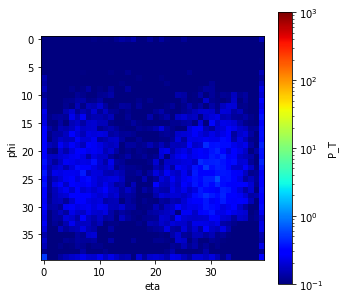

In [83]:
all_images_track_zboson_lepton = []
for idx, xd in enumerate(image_track_eta):
    etas = np.array(image_track_eta[idx])
    phis = np.array(image_track_phi[idx])
    Pts = np.array(image_track_Pt[idx])
    all_images_track_zboson_lepton.append(constit_to_img(etas, phis, Pts, True, True))
    
masked_data = np.ma.masked_equal(np.mean(all_images_track_zboson_lepton, axis = 0), 0.)
#masked_data = all_images_track_zboson_lepton[0]
# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-1, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("P_T")
plt.xlabel("eta")
plt.ylabel("phi")
plt.savefig("Average track picture - Z boson")
#plt.gca().invert_yaxis()
plt.show()




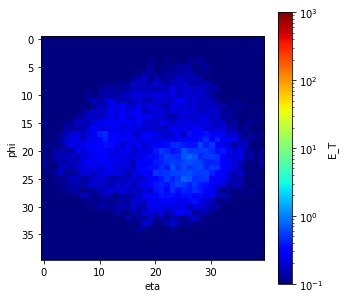

In [84]:
all_images_tower_zboson_lepton = []
for idx_1, xd_1 in enumerate(image_tower_eta):
    etas_2 = np.array(image_tower_eta[idx_1])
    phis_2 = np.array(image_tower_phi[idx_1])
    Ets = np.array(image_tower_Et[idx_1])
    all_images_tower_zboson_lepton.append(constit_to_img(etas_2, phis_2, Ets, True, True))
    
masked_data = np.ma.masked_equal(np.mean(all_images_tower_zboson_lepton, axis = 0), 0.)
#masked_data = all_images_tower_zboson_lepton[0]

# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-1, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("E_T")
plt.xlabel("eta")
plt.ylabel("phi")
plt.savefig("Average tower picture - Z boson")
#plt.gca().invert_yaxis()
plt.show()

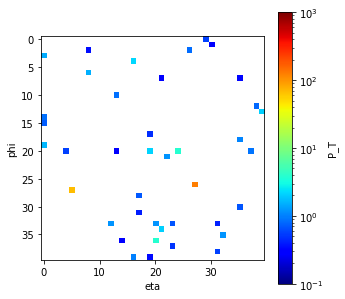

In [89]:
all_images_track_zprimeboson_lepton = []
for idx, xd in enumerate(image_track_eta):
    etas = np.array(image_track_eta[idx])
    phis = np.array(image_track_phi[idx])
    Pts = np.array(image_track_Pt[idx])
    all_images_track_zprimeboson_lepton.append(constit_to_img(etas, phis, Pts, True, True))
    
#masked_data = np.ma.masked_equal(np.mean(all_images_track_zprimeboson_lepton, axis = 0), 0.)
masked_data = all_images_track_zprimeboson_lepton[0]
# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-1, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("P_T")
plt.xlabel("eta")
plt.ylabel("phi")
plt.savefig("Individual track picture - Zprime boson")
#plt.gca().invert_yaxis()
plt.show()




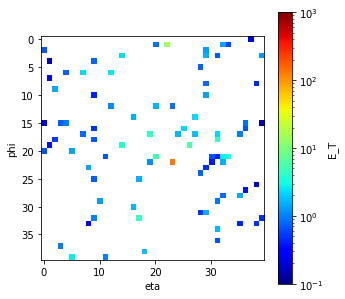

In [90]:
all_images_tower_zprimeboson_lepton = []
for idx_1, xd_1 in enumerate(image_tower_eta):
    etas_2 = np.array(image_tower_eta[idx_1])
    phis_2 = np.array(image_tower_phi[idx_1])
    Ets = np.array(image_tower_Et[idx_1])
    all_images_tower_zprimeboson_lepton.append(constit_to_img(etas_2, phis_2, Ets, True, True))
    
#masked_data = np.ma.masked_equal(np.mean(all_images_tower_zprimeboson_lepton, axis = 0), 0.)
masked_data = all_images_tower_zprimeboson_lepton[0]

# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=10**-1, vmax=10**3)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("E_T")
plt.xlabel("eta")
plt.ylabel("phi")
plt.savefig("Individual tower picture - Zprime boson")
#plt.gca().invert_yaxis()
plt.show()